In [1]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import network
import network.normFlow as nf
import config
import utils
import utils.mathT as mathT
import utils.theanoGeneral as utilsT
import numpy as np
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
DIM = 2
SAMPLINGNUM = 1000

# defining target model, here is a known gaussian
mean = utilsT.sharedf([2.0,1.0])
varmat = utilsT.sharedf( np.eye(DIM)/2. )
logTarget = mathT.multiNormInit(mean,varmat)

In [3]:
# construction variational model
iaf = nf.NormFlowModel(2,4,noisestd=1.)
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)

In [4]:
# setting cost variable
logpz = logTarget(z)
cost = T.mean( logqz - logpz ) # KL cost

In [5]:
params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [6]:
iaf.reInit()
opt = optimizers.SGD(lr=0.05,momentum=0.9,decay=0.001)
updates = opt.getUpdates(params,grads)
estep = theano.function(inputs=[],outputs=[cost,opt.lr,opt.it],updates=updates)

In [7]:
# training
NUMITER = 1000
record = {'cost':[],'lr':[],'iter':[]}
for i in range(NUMITER):
    [c,lr,it] = estep()
    record['cost'].append(c)
    record['lr'].append(lr)
    record['iter'].append(it)

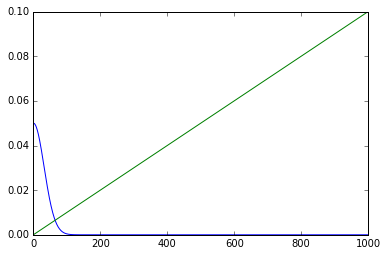

In [12]:
plt.plot( range(NUMITER), record['lr'],'-' )
plt.plot( range(NUMITER), np.asarray(record['iter'])/10000,'-' )
plt.show()

In [40]:
e2 = iaf.getNoiseVar(1000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

(1000, 2) (1000, 2)


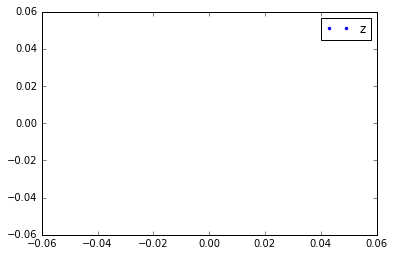

In [41]:
es, zs = fez2()
print es.shape, zs.shape
# plt.plot(es[:,0],es[:,1],'.',label='e')
plt.plot(zs[:,0],zs[:,1],'.',label='z')
plt.legend(loc=1)
plt.show()

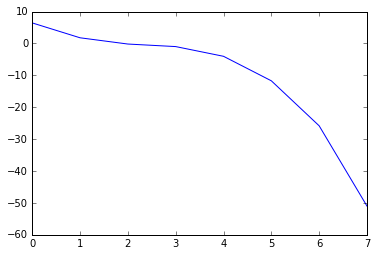

In [42]:
plt.plot( range(NUMITER), record['cost'],'-' )
plt.show()

In [43]:
print record['cost']

[array(6.454113038069517), array(1.7879938692028523), array(-0.17326862912614524), array(-0.9710110542532076), array(-4.018740672137563), array(-11.705495259397338), array(-25.82188272819), array(-51.001321025783085), array(-inf), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), array(nan), a